In [9]:
import pandas as pd

import time
import matplotlib as mpl
from cycler import cycler
import math
import numpy as np
from PyPDF2 import PdfFileMerger
#mpl.use('pgf')
from src.utile import *
import matplotlib.pyplot as plt

mpl.rcParams['lines.linewidth'] = 0.5
mpl.rcParams['lines.linestyle'] = '-'
mpl.rcParams['lines.markersize'] = 1.0
mpl.rcParams["figure.figsize"] = (4,2)
#plt.rc('text', usetex=True)
#plt.rc('font', family='serif')
#plt.rcParams['pgf.preamble'] = [r'\usepackage{hyperref} \hypersetup{hidelinks,''colorlinks=true, urlcolor=cyan}', ]
#plt.rcParams['pgf.preamble'] = [r'\usepackage{hyperref}',]

from platform import python_version
print(python_version())
%load_ext autoreload
%autoreload 2

3.9.7
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
if False:
    plt.rcParams.update({
    "font.family": "serif",  # use serif/main font for text elements
    "text.usetex": True,     # use inline math for ticks
    "pgf.rcfonts": False,    # don't setup fonts from rc parameters
    "pgf.preamble": '\n'.join([
         r'\usepackage{url}',            # load additional packages
         r'\usepackage{unicode-math}',   # unicode math setup
         #r'\setmainfont{DejaVu Serif}'',  # serif font via preamble
         r'\usepackage{hyperref}',
        r'\usepackage{pgfplots}',
        r'\usepgfplotslibrary{external}',
        r'\tikzexternalize{main}',
        r'\tikzsetexternalprefix{external_figs/}',
    ])
    })


In [6]:
cameras = get_camera_names()
days = get_days_in_order()

In [11]:
from matplotlib.backends.backend_pdf import PdfPages

"""
@params days: [(folder, start_time)]
"""
def pdf_for_fish(camera_id, days,is_back=False):
    position_str = get_position_string(is_back)
    
    with PdfPages('trajectory_{}_{}_{}_{}.pdf'.format(
        camera_id,position_str,
        get_date(days[0]), 
        get_date(days[-1])
    )) as pdf:
        for day in days:
            day_df = csv_of_the_day(camera_id, day)
            fig = plot_day_camera(day_df, camera_id, day, is_back=is_back)
            pdf.savefig(fig, bbox_inches='tight')
            
def pdf_for_fish_tex(camera_id,days,is_back=False):
    position_str = get_position_string(is_back)
    
    merger = PdfFileMerger()
    for day in days:
        day_df = csv_of_the_day(camera_id, day)
        fig = plot_day_camera(day_df, camera_id, day, is_back)
        #fig.text(0.5, 0.5, r'\href{https://stackoverflow.com/questions/}{StackOverflow '+day[0]+'}')
        out = './out{}.pdf'.format(day)
        fig.savefig(out, bbox_inches='tight')
        merger.append(out)
        os.remove(out)

    merger.write('./trajectory_{}_{}_{}_{}.pdf'.format(
            camera_id,
            position_str,
            get_date(days[0]), 
            get_date(days[-1])
        ))
    merger.close()
    
def plots_for_tex(camera_list, day_list, dpi=50):
    for is_back in [True, False]:
        fo = set_figure(is_back)
        for camera_id in camera_list:
            for day in day_list:
                day_df = csv_of_the_day(camera_id, day)
                plot_day_camera_fast(day_df, camera_id, day, fo, is_back=is_back, dpi=dpi)
                #plot_day_camera(day_df, camera_id, day, is_back=is_back,write_single_plots=True, dpi=dpi)

In [27]:
tstart = time.time()
plots_for_tex(cameras[:2], days[:2], dpi=100)
print(time.time()-tstart)

14.41100001335144


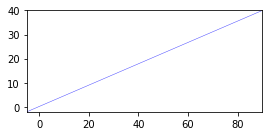

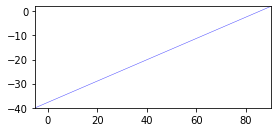

207.4243779182434


In [20]:
tstart = time.time()
plots_for_tex(cameras[:3], days, dpi=100)
print(time.time()-tstart)

In [21]:
cameras[:3]

['23520289', '23484201', '23520258']

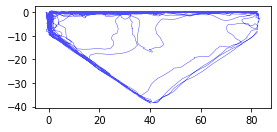

68.8


In [85]:

fig, ax = plt.subplots()
plt.tight_layout()
line, = ax.plot(df[1].x,df[1].y,'b-', alpha=0.7, solid_capstyle="projecting")
plt.show(block=False)
tstart = time.time()
num_plots = 0
while time.time()-tstart < 5:
    idx = num_plots % len(df)
    line.set_data(df[idx].x, df[idx].y)
    #ax.draw_artist(ax.patch)
    #ax.draw_artist(line)
    num_plots += 1
    fig.savefig("out.jpeg")
print(num_plots/5)

In [18]:
ROOT_img = "plots"

def set_figure(is_back=False):
    xlim=[-5, 90]
    ylim=[-40, 2]
    if is_back: ylim=[-2, 40] 
    fig, ax = plt.subplots()
    plt.tight_layout()
    #ax.set_ylabel('y coordinate')
    ax.set_ylim(ylim)
    #ax.set_xlabel('x coordinate')
    ax.set_xlim(xlim)
    line, = ax.plot(xlim, ylim,'b-', alpha=0.7, solid_capstyle="projecting")
    plt.show(block=False)
    return (fig, ax, line)
    
def plot_day_camera_fast(day_df, camera_id, date, figure_obj, is_back=False, dpi=50):
    (fig, ax, line) = figure_obj
    data = day_df[is_back]
    nrows=4
    ncols=4
    position = get_position_string(is_back)
    title="{}\nTrajectory over time of the molly at\n camera: {}\n position: {}".format(
        get_full_date(date),
        camera_id,
        position
    )
    if is_back: ylim=[-2, 40] 
    batch_size= 100
    
    if len(data)==0:
        return None
    
    nr_of_frames = 0
    
    for i in range(nrows):       
        for j in range(ncols):
            if (i == j and j == 0):
                continue
            idx = i * ncols + j - 1
            if idx >= len(data):
                break
            low, up = 0, len(data[idx].x)-1
            
            time_span="{} - {}".format(get_time_for_day(date,nr_of_frames),get_time_for_day(date, nr_of_frames+data[idx].FRAME[up]))
            nr_of_frames+=data[idx].FRAME[up]
            ax.set_title(time_span,fontsize=10)
            
            #for k in range(low, up, batch_size-1):
            line.set_data(data[idx].x, data[idx].y)
            ax.draw_artist(ax.patch)
            ax.draw_artist(line)
            
            data_dir = "{}/{}/{}/{}".format(ROOT_img, position, camera_id, date)
            if not os.path.isdir(data_dir):
                os.makedirs(data_dir, exist_ok=True)
            fig.savefig("{}/{}{}.jpeg".format(data_dir,i,j),bbox_inches='tight', dpi=dpi)
                
    return None

In [58]:
ROOT_img = "plots"

def plot_day_camera(day_df, camera_id, date, is_back=False, write_single_plots=False, dpi=50):
    xlim=[-5, 90]
    ylim=[-40, 2]
    data = day_df[is_back]
    nrows=4
    ncols=4
    position = get_position_string(is_back)
    title="{}\nTrajectory over time of the molly at\n camera: {}\n position: {}".format(
        get_full_date(date),
        camera_id,
        position
    )
    if is_back: ylim=[-2, 40] 
        
    if write_single_plots:
        axis = [[plt for j in range(ncols)] for i in range(nrows)]
    else:
        fig, axis = plt.subplots(figsize=(4*ncols,2*nrows), nrows=nrows, ncols=ncols, sharex=True, sharey=True)
        fig.suptitle(title,x=0.22, y=0.85)
    
    nr_of_frames = 0
    
    for i in range(nrows):
        axis[i][0].ylabel('y coordinate')
        axis[i][0].ylim(ylim)
        
        for j in range(ncols):
            if (i == j and j == 0):
                if not write_single_plots:
                    axis[i][j].axis('off')
                continue
            if (i==nrows-1):
                axis[-1][j].xlabel('x coordinate')
                axis[-1][j].xlim(xlim)
            idx = i * ncols + j - 1
            if idx >= len(data):
                break
            low, up = 0, len(data[idx].x)-1
            label='All trajectory points front '
            batch_size= 100
            time_span="{} - {}".format(get_time_for_day(date,nr_of_frames),get_time_for_day(date, nr_of_frames+data[idx].FRAME[up]))
            nr_of_frames+=data[idx].FRAME[up]
            if write_single_plots:
                axis[i][j].title(time_span,fontsize=10)
            else:
                axis[i][j].set_title(time_span,fontsize=10)
        
            for k in range(low,up, batch_size-1):
                axis[i][j].plot(data[idx].x[k:k+batch_size], data[idx].y[k:k+batch_size],'b-', alpha=0.3, solid_capstyle="projecting")
    # ax.plot(day1[1].x[:limit], day1[1].y[:limit], 'r-', label='All trajectory points back ')
            if write_single_plots:
                data_dir = "{}/{}/{}/{}".format(ROOT_img, position, camera_id, date)
                if not os.path.isdir(data_dir):
                    os.makedirs(data_dir, exist_ok=True)
                plt.savefig("{}/{}{}.png".format(data_dir,i,j), dpi=dpi)
                plt.close()
    
    if write_single_plots:
        return None;
    plt.close(fig)
    return fig

In [332]:

fig = plot_day_camera(day_df, cameras[0], days[0], is_back=True, write_single_plots=True)
#fig.savefig("out_exp.pdf")

In [225]:
pdf_for_fish(cameras[0], days)

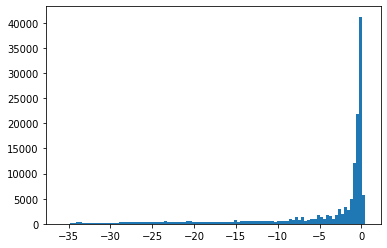

In [94]:
h2 = plt.hist(day1[0].y, bins=100)